In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Obtain faces images from the directory
data_dir = "C:/Users/guokw/Downloads/StarterFiles/StarterFiles/Train1/"
output_dir = "C:/Users/guokw/Downloads/StarterFiles/StarterFiles/Train1_Resized/"


os.makedirs(output_dir, exist_ok=True)
num_images = 0
faces = []

# Loop through each image in the directory
for filename in os.listdir(data_dir):
    if filename.endswith(".jpg"):  # Assuming all face images are in JPG format
        num_images += 1
        # Read the image using matplotlib
        image_path = os.path.join(data_dir, filename)
        img = mpimg.imread(image_path)
        faces.append(img)

# Compute and subtract the mean face
mean_face = np.sum(faces, axis = 0) / num_images
faces -= mean_face

(3772, 150, 130)


In [2]:
# Save the new processed faces
os.makedirs(output_dir, exist_ok=True)
for i in range(len(faces)):
    output_path = os.path.join(output_dir, f"face_{i}.jpg")
    mpimg.imsave(output_path, faces[i], cmap='gray')

In [162]:
# Compute the eigenvectors and eigenvalues
flattened_faces = [face.flatten() for face in faces]
A= np.array(flattened_faces).T

ATA = np.dot(A.T, A)
eigenvalues, eigenvectors = np.linalg.eig(ATA)

sorted_indices = np.argsort(eigenvalues)[::-1]
M_best_eigenvalues = eigenvalues[sorted_indices[:num_images]]
M_best_eigenvectors = eigenvectors[:, sorted_indices[:num_images]]

print(M_best_eigenvectors.shape)

M_best_eigenvectors = np.dot(A, M_best_eigenvectors)

print(M_best_eigenvectors.shape)
normalised_eigenvectors = M_best_eigenvectors / np.linalg.norm(M_best_eigenvectors, axis=0)

print(normalised_eigenvectors.shape)

K = 150

first_K_eigenfaces = normalised_eigenvectors[:, :K]
print(first_K_eigenfaces.shape)

# Project the faces onto the lower dimensional space
projected_faces = np.dot(first_K_eigenfaces.T, A)


(3772, 3772)
(19500, 3772)
(19500, 3772)
(19500, 150)


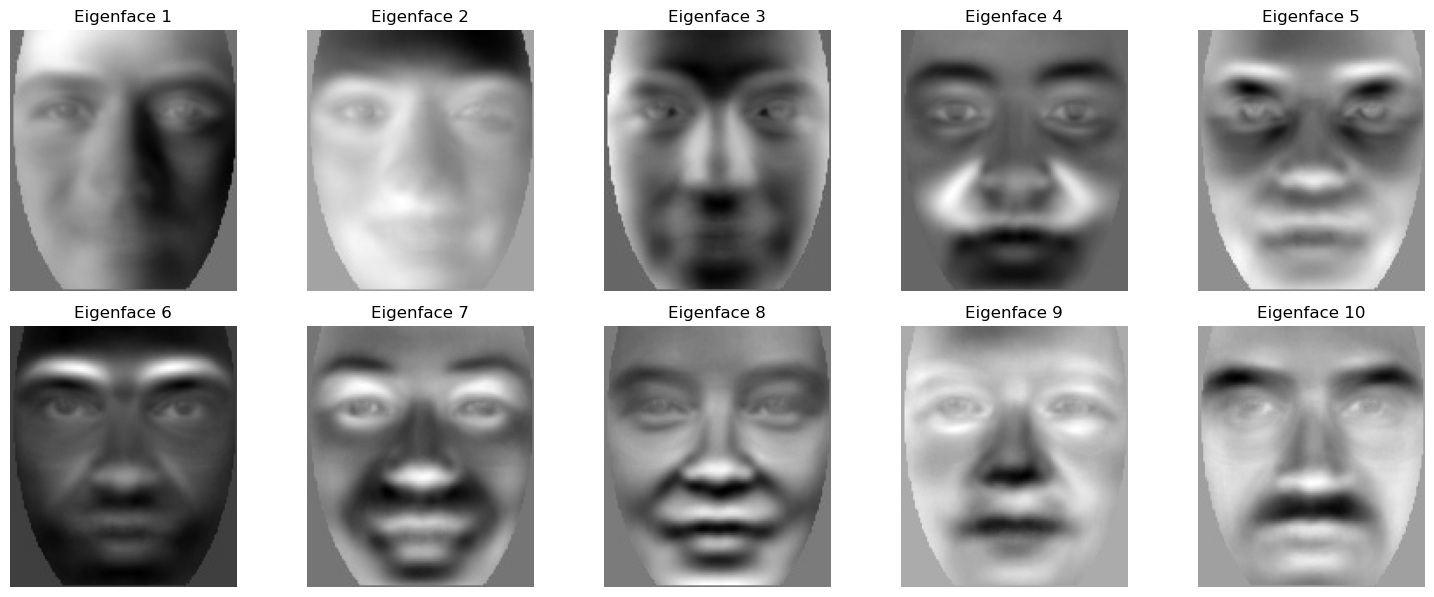

In [59]:
# Display top 10 eigenvectors(eigenfaces)

num_rows = 4
num_cols = 5
plt.figure(figsize=(15, 12))

# Iterate over the first 10 eigenfaces
for i in range(10):
    # Extract the eigenface
    eigenface = first_K_eigenfaces[:, i].reshape((150, 130))
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(eigenface, cmap='gray')
    plt.title(f'Eigenface {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

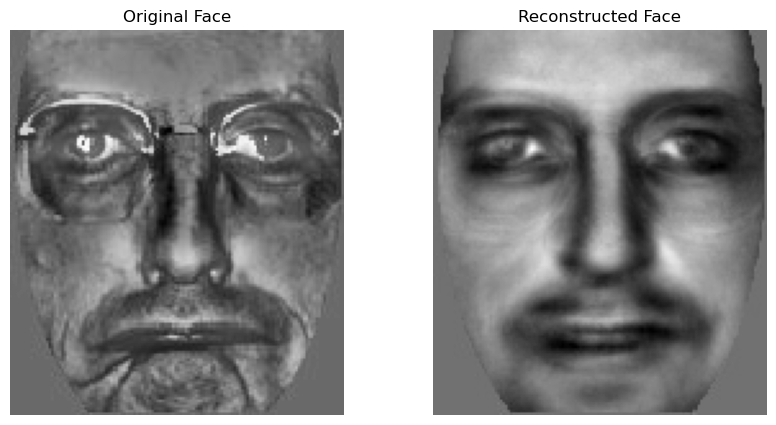

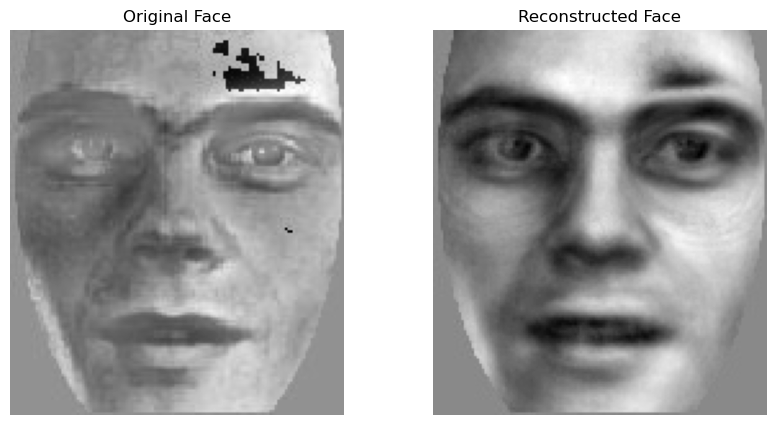

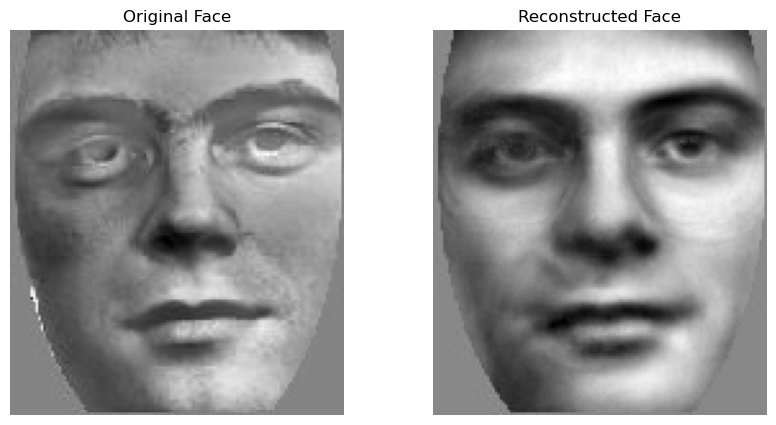

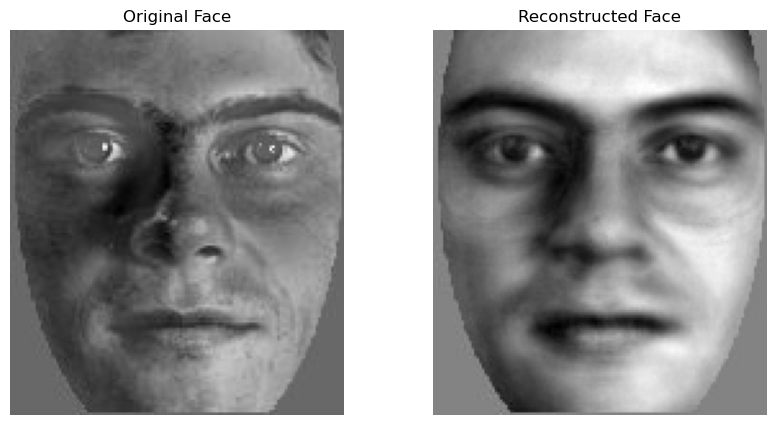

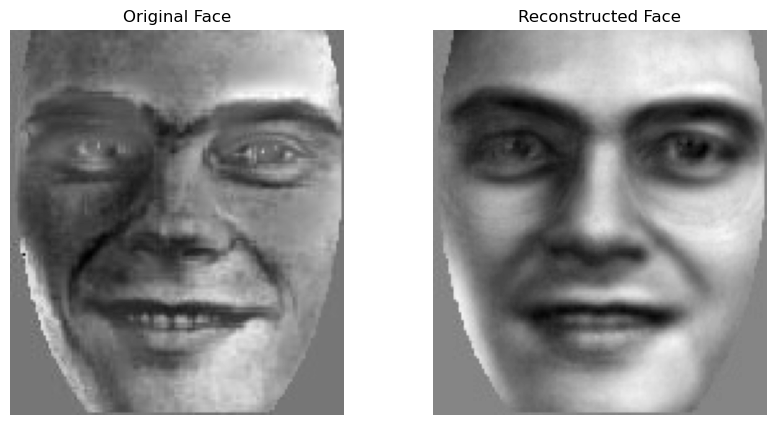

In [60]:
# Represent faces as linear combination of K best eigenvectors and compare with original faces

for i in range(5):
    # Reconstruct the ith face
    reconstructed_face = np.dot(first_K_eigenfaces, projected_faces[:, i])
    reconstructed_face += mean_face.flatten()
    reconstructed_face = np.reshape(reconstructed_face, (150, 130))

    # Display the original and reconstructed faces side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot original face
    axes[0].imshow(faces[i], cmap='gray')
    axes[0].set_title('Original Face')
    axes[0].axis('off')
    
    # Plot reconstructed face
    axes[1].imshow(reconstructed_face, cmap='gray')
    axes[1].set_title('Reconstructed Face')
    axes[1].axis('off')
    
    plt.show()

Number of recognized faces: 34


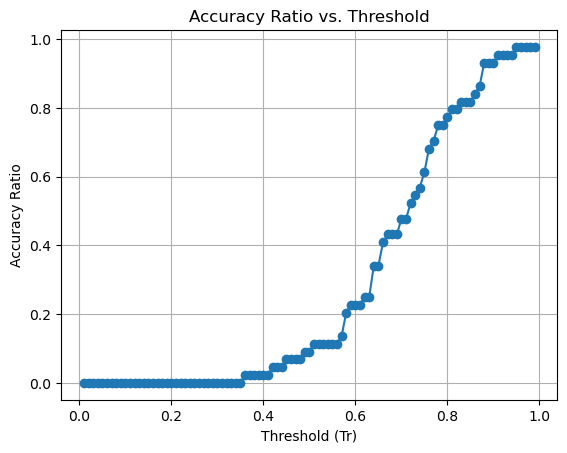

In [163]:
# Perform PCA on test images and recognize the faces

# Read test images
test_dir = "C:/Users/guokw/Downloads/StarterFiles/StarterFiles/Test1/"

test_faces = []

# Loop through each image in the directory
for filename in os.listdir(test_dir):
    if filename.endswith(".jpg"):  # Assuming all face images are in JPG format
        # Read the image using matplotlib
        image_path = os.path.join(test_dir, filename)
        img = mpimg.imread(image_path)
        test_faces.append(img)
    

mean_face = np.mean(test_faces, axis = 0)
test_faces -= mean_face

flattened_test_faces = [face.flatten() for face in test_faces]
A_test = np.array(flattened_test_faces).T

# Project test images onto eigenfaces
weights = np.dot(A_test.T, first_K_eigenfaces)

recognized_count = 0
er_list = []

# Iterate over each test face
for i in range(weights.shape[0]):
    distances = np.linalg.norm(weights[i] - projected_faces.T, axis=1)
    min_distance = np.min(distances)
    er_list.append(min_distance)

# Set the threshold for recognition
Tr = np.max(er_list) * 0.8

for i in range(weights.shape[0]):
    if er_list[i] < Tr:
        recognized_count += 1

print(f"Number of recognized faces: {recognized_count}")

accuracy_ratios = []
threshold_values = []

# Iterate over different threshold values
for threshold_ratio in np.arange(0.01, 1, 0.01):
    # Calculate the threshold
    Tr = np.max(er_list) * threshold_ratio
    threshold_values.append(Tr)

    # Reset recognized count for each threshold
    recognized_count = 0

    # Iterate over each test face
    for i in range(weights.shape[0]):
        if er_list[i] < Tr:
            recognized_count += 1

    # Calculate the accuracy ratio
    accuracy_ratio = recognized_count / len(er_list)
    accuracy_ratios.append(accuracy_ratio)

# Plot the graph
plt.plot(threshold_values/np.max(er_list), accuracy_ratios, marker='o')
plt.xlabel('Threshold (Tr)')
plt.ylabel('Accuracy Ratio')
plt.title('Accuracy Ratio vs. Threshold')
plt.grid(True)
plt.show()

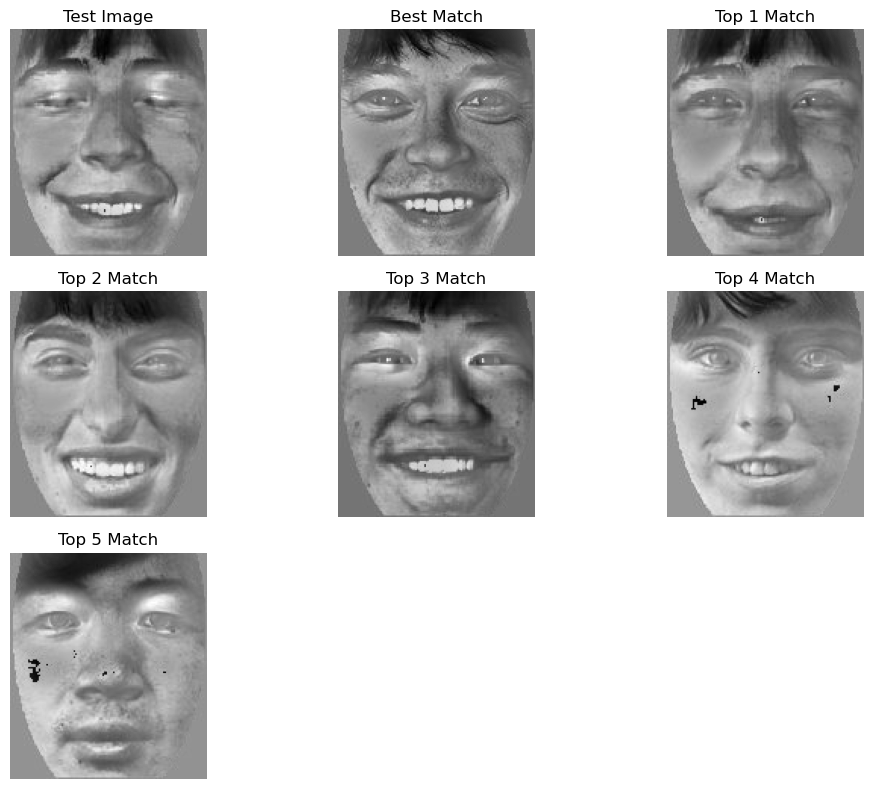

In [164]:
# Chosen test image index
index = 41

# Print best match and top 5 matches
distances = np.linalg.norm(weights[index] - projected_faces.T, axis=1)
best_match_index = np.argmin(distances)

# Sort the distances to find the top 5 matches (excluding the best match)
top_5_matches_indices = np.argsort(distances)[1:6]

# Display the test image, best match, and top 5 matches
plt.figure(figsize=(10, 8))

# Plot the test image
plt.subplot(3, 3, 1)
plt.imshow(test_faces[index], cmap='gray')
plt.title('Test Image')
plt.axis('off')

# Plot the best match
plt.subplot(3, 3, 2)
plt.imshow(faces[best_match_index], cmap='gray')
plt.title('Best Match')
plt.axis('off')

# Plot the top 5 matches
for i, index in enumerate(top_5_matches_indices):
    plt.subplot(3, 3, i+3)  # Adjust the subplot index
    plt.imshow(faces[index], cmap='gray')
    plt.title(f'Top {i+1} Match')
    plt.axis('off')

plt.tight_layout()
plt.show()
